# **DETECTION AND DATA EXTRACTION FROM CREDIT CARD OBJECT**

[![Grounding DINO](https://badges.aleen42.com/src/github.svg)](https://github.com/ultralytics/ultralytics)
[![GLIGEN](https://badges.aleen42.com/src/github.svg)](https://github.com/gligen/GLIGEN)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/zero-shot-object-detection-with-grounding-dino.ipynb)


[![Nahuel Tabasso](https://badges.aleen42.com/src/instagram.svg)](https://www.instagram.com/nahuel.tabasso?igsh=MTBrbnp0MGlqdGc3aA%3D%3D&utm_source=qr)

[![Visual Studio Code](https://badges.aleen42.com/src/visual_studio_code.svg)](https://www.python.org/)
[![Python](https://badges.aleen42.com/src/python.svg)](https://www.python.org/)
[![PyTorch](https://img.shields.io/badge/PyTorch-EE4C2C?style=flat-square&logo=pytorch&logoColor=white)](https://pytorch.org/)
[![Docker](https://badges.aleen42.com/src/docker.svg)](https://www.python.org/)

In this notebook, we are develop a process to detect credit cards from images delivered by user using a fine-tunned **YOLOv10** model. For the task of detecting the elements of the card we will use another fine-tunned **YOLOv10** model. Once these elements are detected, we will extract the data through OCR from each card element. Finally using a fine-tunned **YOLO** classifier, we will determine the card Payment Network


<img src="./assets/process_schema.png" alt="Texto alternativo" style="border-radius: 15px; width: 1400px;"/>

# **BUILD ENVIRONMENT**

First download the model weights

* [YOLOv10n_CardDetector](https://www.python.org/)
* [YOLOv10n_CardElementsDetector](http:dfd)
* [YOLOv8n_PaymentNetworkClassifier](sfsaf)

After download the models, setting the environments variables in `.env` file

```bash
YOLO_CARD_DETECTOR=<value>
YOLO_CARD_ELEMENT_DETECTOR=<value>
YOLO_PAYMENT_NETWORK_CLASSIFIER=<value>
```

In this step you have two option, if you prefer you can build and run the docker image with the follows command

```bash
docker-compose build
```

After built the docker image, run container with the next command
```bash
docker-compose up -d
```

If you prefer build your own local environment follow the next steps:

##### Step 1 - Create a python envinroment

In [ ]:
! python -m pip install pipenv
! python -m pipenv shell

##### Step 2 - Download the requires libraries from requirements.txt and install GroundingDino


In [ ]:
! pip install -r requirements.txt

## **IMPORT LIBRARIES**

In [31]:
from ultralytics import YOLO
from dotenv import load_dotenv
import cv2
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision as tv
import easyocr
import re

#### Load the environments variables in the notebook context

In [27]:
load_dotenv("../../.env")

True

## **FIRST STAGE**

In this first stage of this process, the goal is detect the credit card in an image. To do this, we have a fine-tunned **YOLOv10** model called in this context as `YOLOv10n_CardDetector`.

So, load the model and find a credit/debit card in your image

**IMPORTANT**

**Keep in mind this credit card is not a real card, it is just a test card downloaded from the internet only for the purposes of this notebook**


### **FIRST STEP - LOAD IMAGE**
In the first place, load the image that use as example to work in this notebook

*Note: the `IMAGE_PATH` variable should contain the path of the image that is going to be used in this notebook*

In [7]:
IMAGE_PATH = "./assets/example.jpg"

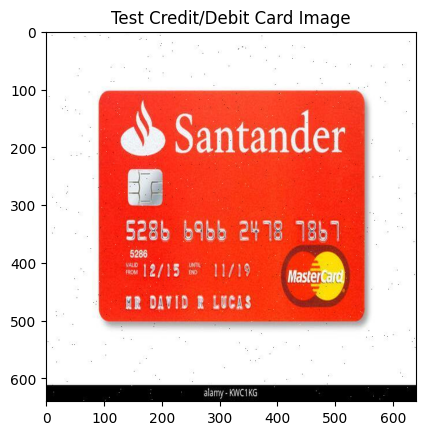

In [13]:
img = cv2.imread(filename=IMAGE_PATH)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Show test image
plt.imshow(img_rgb)
plt.title("Test Credit/Debit Card Image")
plt.show()

### **SECOND STEP - LOAD MODEL**

In this step, load the fine-tunned **YOLOv10** model to made inferences in the nexts steps with the test images.

First, need to define if the inference will run in **"cpu"** or in **"gpu"** or **"mps"** (for Apple Silicon)

To set in our model instance the way in what must to running the inferences, valid the **"cuda"** status with PyTorch in a new variable to set then in our model.

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

#### Instance our YOLO model

In [12]:
# Load card detector model
CARD_DETECTOR_DIR = os.getenv("YOLO_CARD_DETECTOR")
card_detector = YOLO(model=CARD_DETECTOR_DIR)
card_detector

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

### **THIRD STEP - MAKE INFERENCE OVER A TEST IMAGE**

Now in that step, we are going to make the inference on our test image and show the results


0: 640x640 1 credit_card, 121.5ms
Speed: 4.5ms preprocess, 121.5ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)


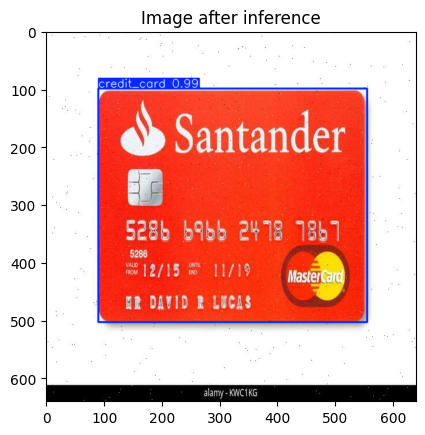

In [15]:
result = card_detector(source=img)

# Show the result
plt.imshow(cv2.cvtColor(result[0].plot(), cv2.COLOR_BGR2RGB))
plt.title("Image after inference")
plt.show()

### **FOUR STEP - CUT OUT THE CARD FROM THE IMAGE**

In our business an image is valid if our model detect only one card, otherwise the input image is not valid

Credit card box -> [90, 99, 555, 503]
Class -> 0.0


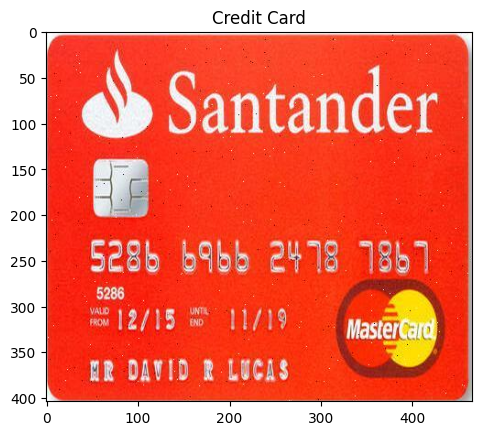

In [22]:
# Validate if the model detected only one credit/debit card, else the image is not valid
xyxy = result[0].boxes.xyxy.cpu().tolist()
clss = result[0].boxes.cls.cpu().tolist()
if len(xyxy) == 1:
    # Cast to int the coordinates
    xyxy = [int(coord) for coord in xyxy[0]]
    print(f"Credit card box -> {xyxy}\nClass -> {clss[0]}")
    credit_card = img[xyxy[1]:xyxy[3], xyxy[0]:xyxy[2]]
    credit_card = cv2.cvtColor(credit_card, cv2.COLOR_BGR2RGB)
    plt.imshow(credit_card)
    plt.title("Credit Card")
    plt.show()
else: 
    print("Image not valid!")

### **FIVE STEP - SHOW RESULTS**

Show the results, now we are showing the original image, annotated image and the cut of credit card

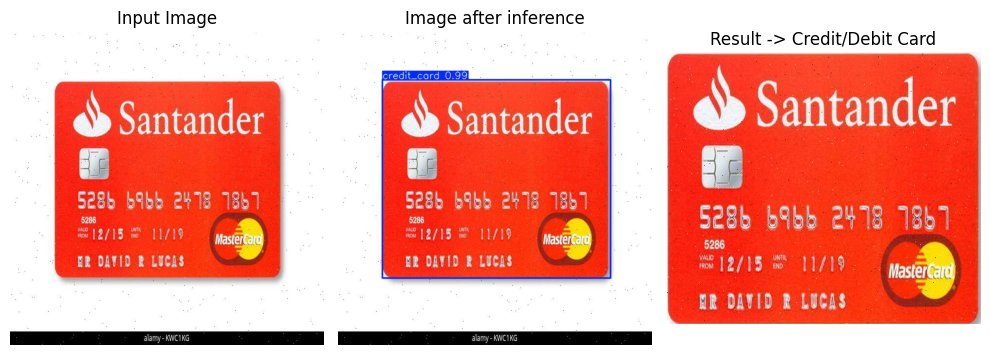

In [25]:
images = [img_rgb, cv2.cvtColor(result[0].plot(), cv2.COLOR_BGR2RGB), credit_card]
labels = ["Input Image", "Image after inference", "Result -> Credit/Debit Card"]

# Create subplots
fig, ax = plt.subplots(1, len(images), figsize=(10, 5))

for index, img in enumerate(images):
    # Show each image in subplot
    ax[index].imshow(img)
    ax[index].set_title(labels[index])
    ax[index].axis('off')

    fig.tight_layout()

plt.show()

## **ENDS THE FIRST STAGE**

With this, it ends the first stage of this process with the cutting of the credit card by `YOLOv10` model, which it is a AI model used to object segmentation, classification and detections in images.

## **SECOND STAGE**

In this stage, we will detect the different elements of credit/debit card using a second fine-tunned **YOLOv10** model called in this context as `YOLOv10n_CreditCardElementsDetector`.

So load the model and detect find the card elements!

**IMPORTANT**

**The following cells will work as long as a card has been detected in the previous step. Otherwise they will produce an error**

### **FIRST STEP - LOAD MODEL**

**NOTE:**

0: Card Number

1: Expiration date

2: Cardholder

3: Payment Network

In [28]:
# Load elements detector model
CARD_ELEMENTS_DETECTOR_DIR = os.getenv("YOLO_CARD_ELEMENT_DETECTOR")
elements_detector = YOLO(CARD_ELEMENTS_DETECTOR_DIR)
elements_detector

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

### **SECOND STEP - DETECT CARD ELEMENTS**

In the follows cells, we will to detect the `Card Number`, `Cardholder`, `Expiration Date` and `Payment Network`


0: 576x640 1 card_number, 1 expiry_date, 1 cardholder, 1 payment_network, 159.4ms
Speed: 25.7ms preprocess, 159.4ms inference, 2.3ms postprocess per image at shape (1, 3, 576, 640)
Boxes
[[198.801513671875, 300.5521545410156, 264.2178955078125, 330.1937561035156], [46.85825729370117, 354.9588623046875, 266.7910461425781, 386.27288818359375], [47.71942138671875, 225.4867706298828, 419.2708740234375, 266.8592834472656], [320.5013732910156, 273.3130798339844, 436.4563903808594, 370.7305603027344]]
Confidences
[1.0, 2.0, 0.0, 3.0]


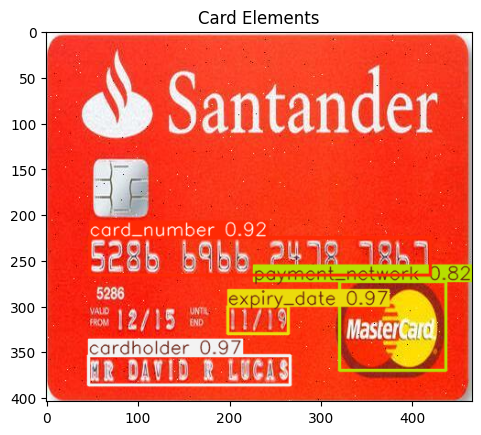

In [49]:
if credit_card is not None:
    result = elements_detector(source=credit_card)
    xyxy = result[0].boxes.xyxy.cpu()
    confs = result[0].boxes.conf.cpu()
    clss = result[0].boxes.cls.cpu()
    
    # Apply NMS
    filtered_id_boxes = tv.ops.nms(boxes=xyxy, scores=confs, iou_threshold=0.5)
    
    # Select and convert the filtered bounding boxes to a list
    xyxy = xyxy[filtered_id_boxes].tolist()
    # Select and convert the filtered class labels to a list
    clss = clss[filtered_id_boxes].tolist()
    
    print(f"Boxes\n{xyxy}")
    print(f"Confidences\n{clss}")
    plt.imshow(result[0].plot())
    plt.title("Card Elements")
    plt.show()

### THIRD STEP - CUT OUT CARD ELEMENTS FROM CREDIT CARD

In [53]:
# Cut the card elements from credit card image
card_number = None
expiry_date = None
cardholder = None
payment_network = None
for box, cls in zip(xyxy, clss):
    # Cast to int the coordinates
    box = [int(coord) for coord in box]
    print(f"Box {box} - cls {cls}")
    if cls == 0.0:
        card_number = credit_card[box[1]:box[3], box[0]:box[2]]
    elif cls == 1.0:
        expiry_date = credit_card[box[1]:box[3], box[0]:box[2]]
    elif cls == 2.0:
        cardholder = credit_card[box[1]:box[3], box[0]:box[2]]
    elif cls == 3.0:
        payment_network = credit_card[box[1]:box[3], box[0]:box[2]]
    else:
        pass

Box [198, 300, 264, 330] - cls 1.0
Box [46, 354, 266, 386] - cls 2.0
Box [47, 225, 419, 266] - cls 0.0
Box [320, 273, 436, 370] - cls 3.0


#### Shows the elements

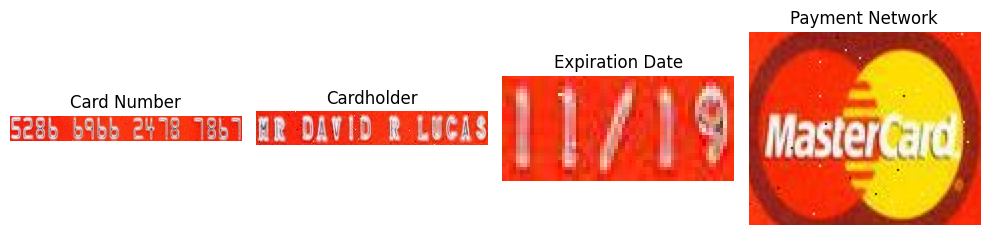

In [54]:
images = [card_number, cardholder, expiry_date, payment_network]
labels = ["Card Number", "Cardholder", "Expiration Date", "Payment Network"]

# Create subplots
fig, ax = plt.subplots(1, len(images), figsize=(10, 5))

index = 0
for image, label in zip(images, labels):
    if image is None:
        image = np.zeros((32, 32, 3), dtype=np.uint8)
        
    ax[index].imshow(image)
    ax[index].set_title(label)
    ax[index].axis('off')
    fig.tight_layout()
    index += 1

plt.show()        

## **ENDS SECOND STAGE**